<a href="https://colab.research.google.com/github/lalit527/DL/blob/master/name_generation_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name Generation

## Get the Data

In [0]:
!curl https://download.pytorch.org/tutorial/data.zip -o data.zip
!unzip data.zip

## Import Libraries

In [0]:
from io import open
import glob
import os
import unicodedata
import string

**Get all Engilsh letters from Python's string library**

In [0]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

***Helper function for returning files from given path***

In [0]:
def find_files(path):
    return glob.glob(path)

***Convert text from unicode to Ascii chaaracters***

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

***Read lines from Individual files***

In [0]:
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

## Read all files:-
- create list of categories from file names
- create list of all lines from the files

In [0]:
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)
print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Japanese', 'Spanish', 'Vietnamese', 'Czech', 'Greek', 'Portuguese', 'Russian', 'German', 'Chinese', 'Dutch', 'Korean', 'Italian', 'French', 'Arabic', 'Irish', 'Polish', 'Scottish', 'English']
O'Neal


## Define the architecture of the Model

In [0]:
import torch
import torch.nn as nn

In [0]:
class RNN(nn.Module):
    def __init__(self, n_categories, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, inputs, hidden):
        input_combined = torch.cat((category, inputs, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

### Defining Training Samples ###

In [0]:
import random

In [0]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [0]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

def random_training_example():
    cat, line = random_training_pair()
    cat_tensor = category_tensor(cat)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return cat_tensor, input_line_tensor, target_line_tensor

### Training Model ###

In [0]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
for p in rnn.parameters():
    print(p.data)

In [0]:
criterion = nn.NLLLoss()
lr = 0.0005
rnn = RNN(n_categories, n_letters, 128, n_letters)

In [0]:
def train(cat_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(cat_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

In [0]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))
        
    if iter % plot_every == 0:
        	all_losses.append(total_loss / plot_every)
        	total_loss = 0

0m 13s (5000 5%) 2.7188
0m 27s (10000 10%) 3.3979
0m 40s (15000 15%) 3.0859
0m 53s (20000 20%) 2.3250
1m 6s (25000 25%) 2.5298
1m 21s (30000 30%) 3.2870
1m 34s (35000 35%) 2.4974
1m 48s (40000 40%) 2.1614
2m 3s (45000 45%) 2.5393
2m 17s (50000 50%) 2.2101
2m 30s (55000 55%) 2.4095
2m 44s (60000 60%) 2.6098
2m 58s (65000 65%) 2.9114
3m 11s (70000 70%) 2.5226
3m 25s (75000 75%) 2.4548
3m 38s (80000 80%) 2.6964
3m 52s (85000 85%) 2.4946
4m 6s (90000 90%) 1.1339
4m 20s (95000 95%) 2.9691
4m 33s (100000 100%) 2.8107


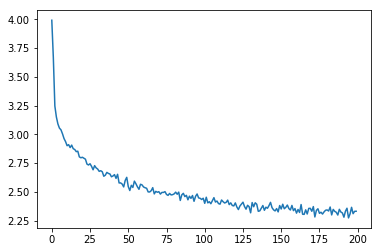

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        cat_tensor = category_tensor(category)
        input_line_tensor = input_tensor(start_letter)
        hidden = rnn.init_hidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(cat_tensor, input_line_tensor[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_line_tensor = input_tensor(letter)
            
        return output_name
    
    
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [0]:
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakov
Uarishiv
Sankinov
Garter
Erer
Roskers
Sollo
Parer
Allan
Can
Han
Iun
